# Data Science Challenge - MeLi

### Bibliotecas

In [40]:
import pandas as pd
import numpy as np
import math 
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from plotnine import *
from collections import ChainMap

import warnings
warnings.filterwarnings('ignore')

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, classification_report, confusion_matrix, precision_recall_curve, average_precision_score, f1_score, log_loss, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate, KFold, cross_val_score, cross_validate
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import pickle

### Dados e EDA

In [2]:
devices_df = pd.read_csv('devices_sensor.csv', encoding="ISO-8859-1")
devices_df.shape

(124494, 12)

In [3]:
devices_df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


Para conhecer os melhor os dados, podemos destacar algumas informações básicas como seu tipo, percentual de valores nulos e a cardinalidade de valores únicos.

In [4]:
summary_devices_df = pd.DataFrame({'column':devices_df.columns})
summary_devices_df['dtype'] = devices_df.dtypes.values
summary_devices_df['na_perc'] = devices_df.isna().sum().values/devices_df.shape[0]
summary_devices_df['unique_values'] = devices_df.nunique().values
summary_devices_df['example_values'] = devices_df.apply(lambda x: x.unique()[0:5]).values
summary_devices_df['min_value'] = devices_df.apply(lambda x: x.min()).values
summary_devices_df['max_value'] = devices_df.apply(lambda x: x.max()).values
summary_devices_df

,column,dtype,na_perc,unique_values,example_values,min_value,max_value
0,date,object,0.0,304,"[2015-01-01, 2015-01-02, 2015-01-03, 2015-01-0...",2015-01-01,2015-11-02
1,device,object,0.0,1169,"[S1F01085, S1F0166B, S1F01E6Y, S1F01JE0, S1F01...",S1F01085,Z1F2PBHX
2,failure,int64,0.0,2,"[0, 1]",0,1
3,attribute1,int64,0.0,123877,"[215630672, 61370680, 173295968, 79694024, 135...",0,244140480
4,attribute2,int64,0.0,558,"[56, 0, 1536, 168, 5160]",0,64968
5,attribute3,int64,0.0,47,"[0, 3, 1, 323, 266]",0,24929
6,attribute4,int64,0.0,115,"[52, 0, 41, 1, 9]",0,1666
7,attribute5,int64,0.0,60,"[6, 12, 15, 8, 19]",1,98
8,attribute6,int64,0.0,44838,"[407438, 403174, 237394, 410186, 313173]",8,689161
9,attribute7,int64,0.0,28,"[0, 16, 8, 48, 32]",0,832


#### Estatística descritiva de variáveis numéricas

In [5]:
devices_df.describe()

,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
count,124494.000000,1.244940e+05,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000
mean,0.000851,1.223881e+08,159.484762,9.940455,1.741120,14.222669,260172.657726,0.292528,0.292528,12.451524
std,0.029167,7.045933e+07,2179.657730,185.747321,22.908507,15.943028,99151.078547,7.436924,7.436924,191.425623
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000
25%,0.000000,6.128476e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000
50%,0.000000,1.227974e+08,0.000000,0.000000,0.000000,10.000000,249799.500000,0.000000,0.000000,0.000000
75%,0.000000,1.833096e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000,0.000000
max,1.000000,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,832.000000,18701.000000


Há variáveis com uma concentração alta de zeros. Vamos dar uma olhada no percentual de zeros para cada variável.

In [6]:
(devices_df==0).sum()/devices_df.shape[0]*100

date           0.000000
device         0.000000
failure       99.914855
attribute1     0.008836
attribute2    94.872042
attribute3    92.662297
attribute4    92.499237
attribute5     0.000000
attribute6     0.000000
attribute7    98.828859
attribute8    98.828859
attribute9    78.202966
dtype: float64

#### Checagem de duplicidade no dataset

In [7]:
devices_df.duplicated().sum()

1

Há apenas uma linha duplicada em todas as colunas. Vamos remove-la.

In [8]:
devices_df.drop_duplicates(inplace=True)

In [9]:
devices_df.shape

(124493, 12)

#### Distribuição da variável Target (failure)

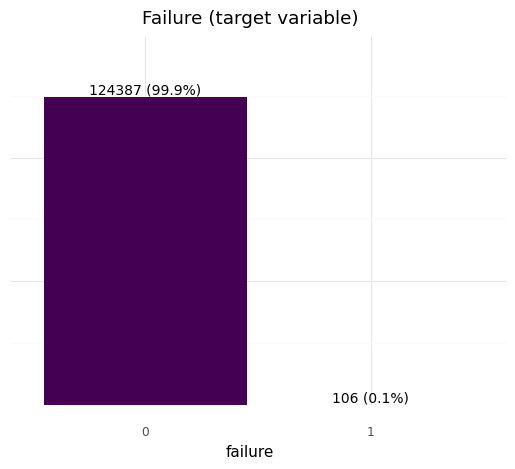

<ggplot: (357678801)>

In [10]:
target_tb = pd.DataFrame(devices_df.failure.value_counts()).reset_index()
target_tb['perc'] = target_tb['count']/devices_df.shape[0]
target_tb['label'] = target_tb.apply(lambda x: str(round(x['count'])) + ' (' + str(round(x['perc']*100,1)) + '%)', axis=1)

(
    ggplot(target_tb)  
    + aes(x="factor(failure)", y="count", label="label", fill="failure")  
    + theme_minimal()
    + geom_col()  
    + geom_text(va="bottom", size=10)
    + scale_y_continuous(expand=(0, 0, 0.2, 0)) 
    + labs(title='Failure (target variable)',x='failure',y='')
    + theme(legend_position="none",
            axis_text_y = element_blank()) 
)

Notamos que os dados são altamente desbalanceados, o que precisa ser aderessado de forma adequada. Em outras palavras, um modelo com output da classe majoritária (sem falha) resultaria em uma acurácia de 99.9% das causas, mesmo perdendo todos os casos positivos.

Como os dados são históricos, vamos dar uma olhada para entender se a distribuição é uniforme entre os dias.

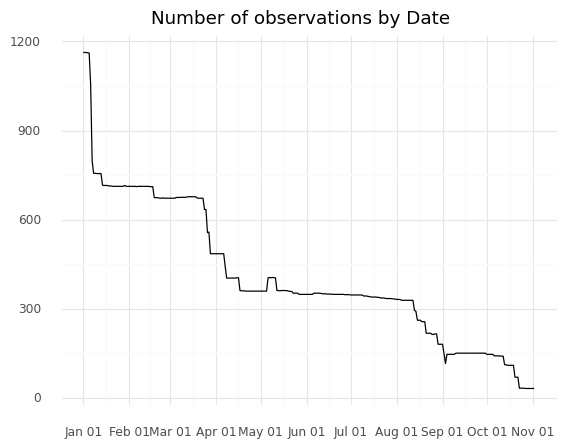

<ggplot: (357683720)>

In [11]:
(
    ggplot(devices_df.groupby(['date'])['device'].agg('count').reset_index())  
    + aes(x="date", y="device", group=1)  
    + theme_minimal()
    + geom_line()  
    + scale_y_continuous() 
    + scale_x_date(date_labels= "%b %d")
    + labs(title='Number of observations by Date',x='',y='')
)

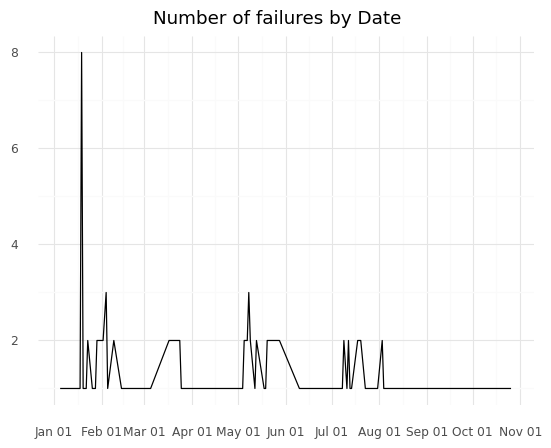

<ggplot: (357741863)>

In [12]:
(
    ggplot(devices_df[devices_df['failure']==1].groupby(['date'])['device'].agg('count').reset_index())  
    + aes(x="date", y="device", group=1)  
    + theme_minimal()
    + geom_line()  
    + scale_y_continuous() 
    + scale_x_date(date_labels= "%b %d")
    + labs(title='Number of failures by Date',x='',y='')
)

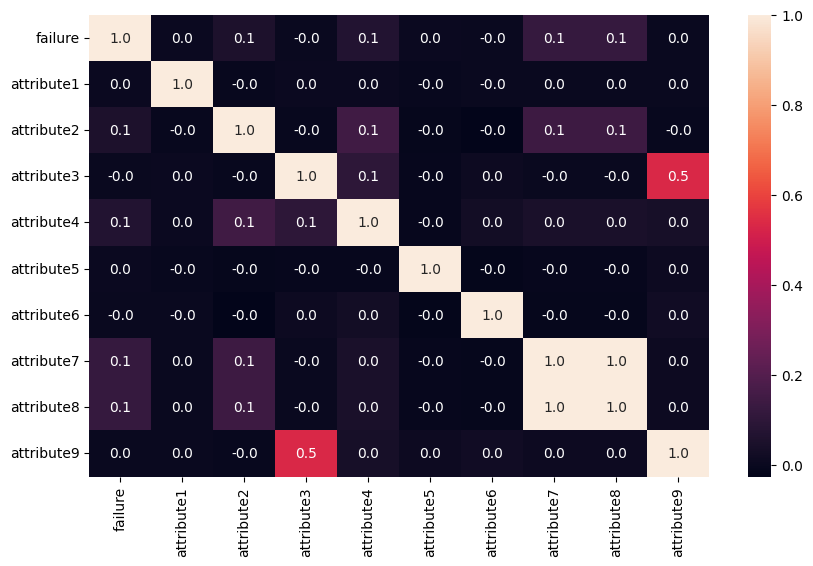

In [13]:
# Correlação entre variáveis
corr_matrix = devices_df.select_dtypes(include=np.number).corr()

# plot the heatmap
plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, 
        xticklabels=corr_matrix.columns,
        yticklabels=corr_matrix.columns, annot = True, fmt = ".1f")
plt.show()

There is a perfect correlation between attribute7 and attribute8, so one of them will be removed.

In [14]:
devices_df.drop('attribute8', axis=1, inplace=True)

In [57]:
sns.pairplot(devices_df.select_dtypes(include=np.number), hue="failure")
plt.show()

### Modeling

Temos um problema de Classificação e testaremos os seguintes algoritmos:
- Regressão Logística
- Árvore de Decisão
- Floresta Aleatória
- LightGBM
- XGBoost

<br> Será utilizado alguns parâmetros como baseline, para depois ser feito uma melhor escolha.

In [15]:
seed=42
lr_modeldefault = LogisticRegression(random_state=seed, penalty='l2', C=1.0)
dt_modeldefault = DecisionTreeClassifier(random_state=seed, criterion='gini', max_depth=5, min_samples_split=5, min_samples_leaf=5)
rf_modeldefault = RandomForestClassifier(random_state=seed, n_estimators=100, criterion='gini', max_depth=10, min_samples_split=5, min_samples_leaf=5)
lgm_modeldefault = LGBMClassifier(random_state=seed, learning_rate=0.1, n_estimators=100, max_depth=10, subsample=0.8, colsample_bytree=0.8)
xgb_modeldefault = XGBClassifier(random_state=seed, learning_rate=0.1, n_estimators=100, max_depth=10, subsample=0.8, colsample_bytree=0.8)

models_list = [('Log. Regression.',lr_modeldefault), 
               ('Decision Tree',dt_modeldefault), 
               ('Random Forest',rf_modeldefault),
               ('LGBM',lgm_modeldefault), 
               ('XGB',xgb_modeldefault)]

#### Dataset split

Para a modelagem, devemos separar os dados entre um dataset de treino e um dataset de teste para podermos validar o poder de generalização do modelo final. <br> Como vimos que os dados históricos não possui uniformidade de observação, utilizaremos uma validação Hold Out aleatória.
<br> Vamos adotar um split de 80% treino / 20% teste. Por conta do desbalanceamento da variável target, adotaremos uma amostragem estratificada para certificar de que haverá representação da classe minoritária em ambos datasets de forma consistente.

In [16]:
X = devices_df.drop(['date','device','failure'], axis=1)
y = devices_df['failure']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed, stratify=devices_df['failure'])

Alguns modelos são sensíveis a diferentes escalas de variáveis e a normalização é aconselhável (muitas vezes necessária), para prevenir resultados não confiáveis e a não convergência, especialmente em modelos baseados em distância. Um dos modelos que podem ser beneficiados com a normalização dos dados é a Regressão Logística, então realizaremos uma normalização dos dados com base nos dados de treino.
<br> Note que modelos a base de árvore não precisam deste processo e portanto, a realização (ou não realização) não altera os resultados.
<br> Há diferentes técnicas, usaremos o Min-Max Scaler.

In [18]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform(X_test)

Vamos também comparar as seguintes técnicas de resampling:
- Undersampling
- Oversampling
- SMOTE (Synthetic Minority Oversampling Technique)

Para isso, é escolhido um ratio que determina quanto da classe majoritária será reduzida (no caso de Under Sampling) e quanto da classe minoritária será duplicada (no caso de Over Sampling). Adotaremos o ratio de 1 que significa que nossa base final estará balanceada 50/50, mas esse ratio pode ser tunado para encontrar o valor mais apropriado.

In [19]:
oversample = RandomOverSampler(sampling_strategy=1, random_state=seed)
undersample = RandomUnderSampler(sampling_strategy=1, random_state=seed)
smote = SMOTE(sampling_strategy=1, random_state=seed)

In [20]:
X_over, y_over = oversample.fit_resample(X_train_scale, y_train)
X_under, y_under = undersample.fit_resample(X_train_scale, y_train)
X_smote, y_smote = smote.fit_resample(X_train_scale, y_train)

training_list = [(None, X_train_scale, y_train),('Over' ,X_over, y_over),('Under', X_under, y_under),('SMOTE', X_smote, y_smote)]

In [21]:
def run_models(X_train, y_train, X_test, y_test, prefix=None):
  results = []
  names = []
  dfs = []
  y_pred_list = []
  scoring = ['precision', 'recall', 'f1']
  for name, model in models_list:
    if prefix is not None:
      name = prefix + '_' + name
    kfold = KFold(n_splits=5, shuffle=True, random_state=seed)
    cv_results = cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring, return_train_score=True)
    clf = model.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_list.append((name,y_pred))
    results.append(cv_results)
    names.append(name)
    this_df = pd.DataFrame(cv_results)
    this_df['model'] = name
    dfs.append(this_df)
    final = pd.concat(dfs, ignore_index=True)
    dct = dict(ChainMap(*reversed([{f'{k}_mean': (k, 'mean'), f'{k}_std': (k, 'std')} for k in [i for i in final.columns if i != 'model']])))
    final = final.groupby('model').agg(**dct)
    final = final.reset_index()
   
  return final, y_pred_list

In [22]:
final = []
y_pred_list = []
for tr in training_list:
    final_, y_pred_list_ = run_models(tr[1], tr[2], X_test_scale, y_test, prefix=tr[0])
    final.append(final_)
    y_pred_list.append(y_pred_list_)
final = pd.concat(final, ignore_index=True)

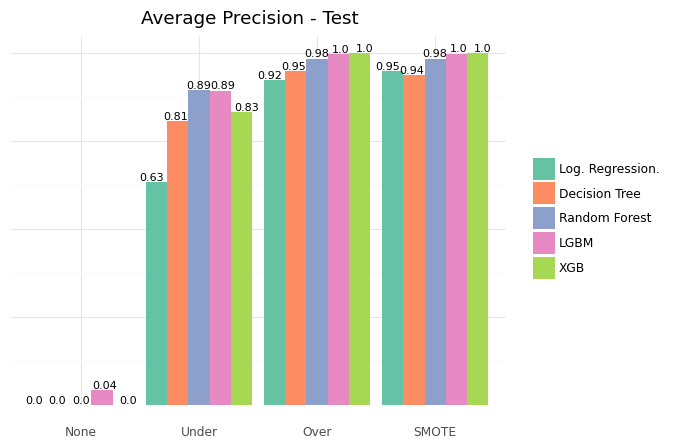

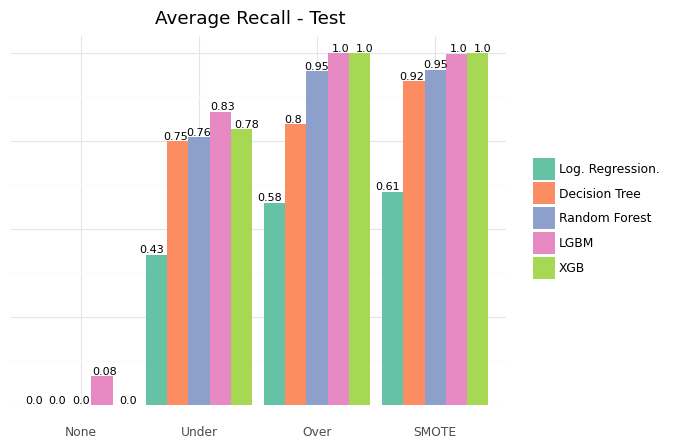

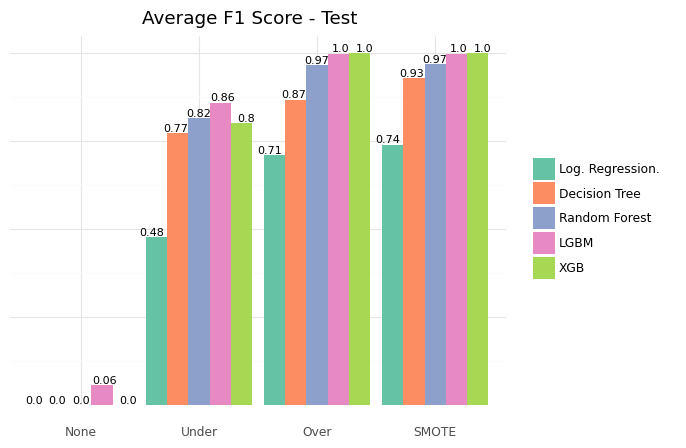

In [23]:
def sampling_used(row):
    if row['model'].split('_')[0]=='Over':
        return 'Over'
    elif row['model'].split('_')[0]=='Under':
        return 'Under' 
    elif row['model'].split('_')[0]=='SMOTE':
        return 'SMOTE' 
    else:
        return 'None'
    
final_viz = final.copy()
final_viz['sampling'] = final_viz.apply(sampling_used, axis=1)
final_viz['model_name'] = final_viz['model'].apply(lambda x: x.split('_')[0] if len(x.split('_'))==1 else x.split('_')[1])
final_viz['model_name'] = pd.Categorical(final_viz['model_name'], categories=[i[0] for i in models_list], ordered=True)
final_viz['sampling'] = pd.Categorical(final_viz['sampling'], categories=['None','Under','Over','SMOTE'], ordered=True)

for title, var in [('Precision','test_precision_mean'),
          ('Recall','test_recall_mean'),
          ('F1 Score','test_f1_mean')]:
    label_ = "round(" + var + ",2)"
    print(
    ggplot(final_viz)  
    + aes(x="factor(sampling)", y=var, label=label_, fill="model_name")  
    + theme_minimal()
    + geom_col(position = "dodge")  
    + geom_text(va="bottom", size=8, position = position_dodge(width = 1))
    + scale_y_continuous(expand=(0, 0, 0.05, 0)) 
    + labs(title='Average ' + title + ' - Test',x='',y='')
    + theme(legend_title=element_blank(),
            axis_text_y = element_blank()) 
    + scale_fill_brewer(type='qual', palette=7)
) 


Podemos observar que para todos os modelos, as técnicas de Over Sampling e SMOTE performam melhor. Como não houve uma grande melhora ao adotar o SMOTE em relação ao Over Sampling e a performance foi similar, seguiremos com o último, por conta da técnica de SMOTE introduzir dados sintéticos, o que pode aumentar viés e adicionar ruído caso esses dados não representem a realidade.

Vamos agora analisar os resultados dos modelos na base de teste, comparando as curvas de Precision-Recall.

In [25]:
val_tb = pd.DataFrame()

for i in range(len(models_list)):
  val_ = pd.DataFrame({'Model':[models_list[i][0]],
                                       'Precision':[precision_score(y_test,y_pred_list[1][i][1])],
                                       'Recall':[recall_score(y_test,y_pred_list[1][i][1])],
                                       'F1 Score':[f1_score(y_test,y_pred_list[1][i][1])]}
                                       )
  val_tb = pd.concat([val_tb, val_], axis=0)

val_tb

,Model,Precision,Recall,F1 Score
0,Log. Regression.,0.009259,0.523810,0.018197
0,Decision Tree,0.011204,0.571429,0.021978
0,Random Forest,0.005128,0.095238,0.009732
0,LGBM,0.028846,0.142857,0.048000
0,XGB,0.000000,0.000000,0.000000


Por fim, notamos uma melhor performance no modelo LGBM através da métrica F1 Score. Podemos realizar o hyperparameter tuning para encontrar o melhor conjunto que resulta no melhor modelo.
Para isso, é possível usar o GridSearch, que busca de forma exaustiva um determinado espaço de parâmetros. Porém, devido a alta quantidade de tempo que é demandada para isso, o RandomSearch é preferível.

In [48]:
lgbm_null = LGBMClassifier()
# Pela limitação de tempo, testarei apenas as 50 primeiras combinações aleatórias
random_grid = {'learning_rate': [0.05, 0.1, 0.2],
               'n_estimators': [50, 100, 200],
               'max_depth': [3, 5, 7, 10],
               'subsample': [0.5, 0.7, 0.9, 1.0],
               'colsample_bytree': [0.5, 0.7, 0.9, 1.0],
               'reg_alpha': [0, 0.1, 0.5, 1.0],
               'reg_lambda': [0, 0.1, 0.5, 1.0]
               }
clf = RandomizedSearchCV(lgbm_null, random_grid, random_state=seed, n_iter=10, cv=5, verbose=1, return_train_score=True, scoring='f1')
clf.fit(X_over,y_over)
clf.best_params_
clf_final = LGBMClassifier(**clf.best_params_).fit(X_over,y_over)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [49]:
clf.best_params_

{'subsample': 0.9,
 'reg_lambda': 0.1,
 'reg_alpha': 0.5,
 'n_estimators': 200,
 'max_depth': 5,
 'learning_rate': 0.1,
 'colsample_bytree': 0.9}

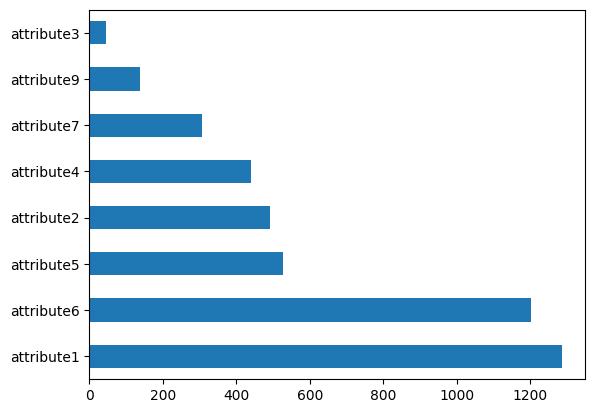

In [50]:
pd.Series(clf_final.feature_importances_, index=X_train.columns).nlargest(10).plot(kind='barh')
plt.show()

In [51]:
val_tb = pd.DataFrame()
pred_train = clf_final.predict(X_train_scale)
pred_test = clf_final.predict(X_test_scale)

for i in range(len(models_list)):
  val_ = pd.DataFrame({'Model':[models_list[i][0]],
                                       'Precision - Train':[precision_score(y_train,pred_train)],
                                       'Recall - Train':[recall_score(y_train,pred_train)],
                                       'F1 Score - Train':[f1_score(y_train,pred_train)],
                                       'Precision - Test':[precision_score(y_test,pred_test)],
                                       'Recall - Test':[recall_score(y_test,pred_test)],
                                       'F1 Score - Test':[f1_score(y_test,pred_test)]
                                       }
                                       )
  val_tb = pd.concat([val_tb, val_], axis=0)

val_tb

,Model,Precision - Train,Recall - Train,F1 Score - Train,Precision - Test,Recall - Test,F1 Score - Test
0,Log. Regression.,0.318352,1.0,0.482955,0.017857,0.047619,0.025974
0,Decision Tree,0.318352,1.0,0.482955,0.017857,0.047619,0.025974
0,Random Forest,0.318352,1.0,0.482955,0.017857,0.047619,0.025974
0,LGBM,0.318352,1.0,0.482955,0.017857,0.047619,0.025974
0,XGB,0.318352,1.0,0.482955,0.017857,0.047619,0.025974


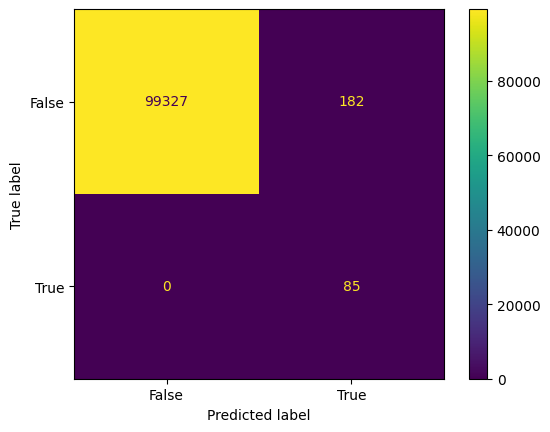

In [52]:
cm_matrix = confusion_matrix(y_train,pred_train)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

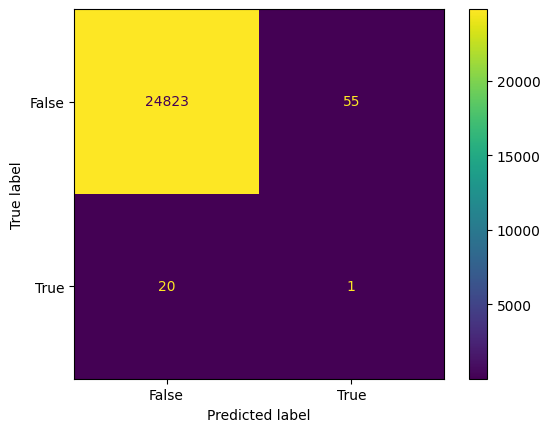

In [56]:
cm_matrix = confusion_matrix(y_test,pred_test)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

O modelo final não resultou predições boas. Como o resultado do Cross Validation foi alto, há um problema de overfitting. 

<br> Algumas notas de possíveis melhorias:
- Entendimento mais a fundo das variáveis, seus significados, importâncias e ruídos
    - Há uma alta concentração de zeros. O que seriam esses valores? Seriam equivalentes a falta de informação (NA)?
    - Identificação de possíveis outliers e a remoção dos mesmos
    - Testar outras técnicas para padronização dos dados
    - Feature selection das variáveis (eliminação de possíveis ruídos)
    - Alguma variável numérica era na verdade categórica e deve ser tratada como tal? Dumificação, Target encoding, etc
- Hyperparameter tuning
    - Neste desafio, foi testado apenas combinações baseline dos modelos, e mesmo o LGBM que foi realizado o GridSearch para ilustração, foi feito apenas 10 iterações pela limitação de tempo e capacidade de máquina
    - Teste de outras soluções mais robustas, como por exemplo, buscas bayesianas de parâmetros (ex: HyperOpt)
    - Testar mais a fundo regularizações, por conta do overfitting.
- Business/Limitações
    - Há outros dados que seria possível incluir no modelo? É possível juntar com outras fontes?
    - Feature engineering (criação de novas variáveis a partir das existentes)
    - Há mais dados históricos para complementar os dados?

### Salvando modelo final

In [46]:
file_name = "xgb_devices_failure.pkl"
with open(file_name, 'wb') as file:
    pickle.dump(clf_final, file)